Reads stories from the validation file. Each sentence has two possible outcomes: either the 5th or 6th sentence. The label (1 or 2) indicates which sentence contains the correct ending.

In [58]:
import warnings
warnings.filterwarnings(action='once')

In [34]:
import pandas as pd
df = pd.read_csv('data/data_val.csv')
df.head()

,InputStoryid,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2,AnswerRightEnding
0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1
1,bff9f820-9605-4875-b9af-fe6f14d04256,Laverne needs to prepare something for her fri...,She decides to bake a batch of brownies.,She chooses a recipe and follows it closely.,Laverne tests one of the brownies to make sure...,The brownies are so delicious Laverne eats two...,Laverne doesn't go to her friend's party.,1
2,e8f628d5-9f97-40ed-8611-fc0e774673c4,Sarah had been dreaming of visiting Europe for...,She had finally saved enough for the trip.,She landed in Spain and traveled east across t...,She didn't like how different everything was.,Sarah then decided to move to Europe.,Sarah decided that she preferred her home over...,2
3,f5226bfe-9f26-4377-b05f-3d9568dbdec1,Gina was worried the cookie dough in the tube ...,She was very happy to find she was wrong.,The cookies from the tube were as good as from...,Gina intended to only eat 2 cookies and save t...,Gina liked the cookies so much she ate them al...,Gina gave the cookies away at her church.,1
4,69ac9b05-b956-402f-9fff-1f926ef9176b,It was my final performance in marching band.,I was playing the snare drum in the band.,We played Thriller and Radar Love.,The performance was flawless.,I was very proud of my performance.,I was very ashamed of my performance.,1


vld set contains both true and fake stories, roc set only the true stories

In [2]:
import nltk
import numpy as np

def read_data(file, data_type = 'val'):
    data = pd.read_csv(file)
    stories = []; labels = []
    for _, row in data.iterrows():
        story = {}
        if data_type == 'roc':
            story['ctx'] = [nltk.word_tokenize(sentence.lower()) for sentence in list(row[2:6])]
            story['ends'] = nltk.word_tokenize(row[6].lower())
            stories.append((story,))
            labels.append(+1)
        if data_type == 'val':
            story['ctx'] = [nltk.word_tokenize(sentence.lower()) for sentence in list(row[1:5])]
            story['ends'] = [nltk.word_tokenize(sentence.lower()) for sentence in list(row[5:7])]
            stories.append(story.copy())
            labels.append(row[7])
    return stories, np.array(labels)

In [3]:
stories, labels = read_data('data/data_val.csv')

Load the pre-trained embeddings

In [4]:
from gensim import models
model = models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

In [5]:
import numpy as np
dim_embedding = 300

np.random.seed(10)
UKN = np.random.uniform(low=-0.25, high=0.25, size=dim_embedding)

def w2v(token):
    try:
        return model[token]
    except:
        return UKN

def centroid(tokens):
        if len(tokens) == 0:
            return np.zeros(shape = [dim_embedding,])
        else:
#             for token in tokens:
#                 print(token, w2v(token)[0:10])
            return np.mean([w2v(token) for token in tokens], axis = 0)
    
def cosine(vec1, vec2):
    if np.sum(vec1**2)*np.sum(vec2**2) == 0:
        return 0
    else:
        return np.sum(vec1*vec2)/np.sqrt(np.sum(vec1**2)*np.sum(vec2**2))

Centroid feature: concatenates the centroid of the context with the centroid of the ending

In [6]:
def centroid_feature(story):
    ctr_context = np.mean([centroid(sentence) for sentence in story['ctx']], axis = 0)
    return np.concatenate([ctr_context, centroid(story['end'])])

Average similarity: computes cosine distance between the centroid vector of the ending and vectors of the words in the context. Similarity scores of the words with top_N highest scores are returned as the feature

In [7]:
def average_sim(story, top_N = [1,2,3,5]):
    ctx_embeddings = [w2v(token) for token in list(set(sum(story['ctx'],[])))]
    words_similarity = sorted([cosine(embedding, centroid(list(set(story['end'])))) for embedding in ctx_embeddings], reverse = True)
    top_similarities = np.asarray([words_similarity[id] for id in top_N])
    return top_similarities

Max similarity: for each word in the context, chooses the most similar word from the ending and takes the average of all best word pair similarities

In [8]:
def max_sim(story):
    words_similarity = []
    for token in list(set(sum(story['ctx'],[]))):
        words_similarity.append(
                    np.max([cosine(w2v(token),w2v(token_end)) for token_end in story['end']])
                    )
    return [np.mean(words_similarity)]

For all combinations (POS1, POS2) in the context and ending computes centroid similarity between all words of type POS1 in the context and all words of type POS2 in the ending

In [9]:
def pos_sim(story, POS = ['VBZ','VBN','VBP','VBG','VBD','VB','RBS','RBR','RB','POS','NN','NNS','JJS','JJR','JJ']):
    POS_context = nltk.pos_tag(sum(story['ctx'],[]))
    POS_end = nltk.pos_tag(story['end'])

    pos_sim = []
    for pos1 in POS:
        for pos2 in POS:
            ctr_context = centroid([token for token, pos in POS_context if pos == pos1])
            ctr_end = centroid([token for token, pos in POS_end if pos == pos2])
            pos_sim.append(cosine(ctr_context, ctr_end))

    return np.array(pos_sim)

In [128]:
from utils import update_progress

def get_features(stories):
    
    X = []
    for item in stories:
        story = {}; features = []
        for end in item['ends']:
            story['ctx'] = item['ctx']
            story['end'] = end
            X_story = np.concatenate([feature(story) 
                                       for feature in [centroid_feature, average_sim, max_sim, pos_sim]])
            features.append(X_story)
        X.append(np.stack(features))
    return np.stack(X)

def get_y(labels):
    y = []
    for label in labels:
        y.append(np.array([1,0])) if label == 1 else y.append(np.array([0,1]))
    return np.stack(y)

In [40]:
def predict_labels(clf, X):
    labels = []
    X = normalize(X.reshape([2*X.shape[0],-1]), axis = 1).reshape(X.shape[0],2,-1)
    for x in X:
        prob_true = clf.predict_proba(x)[:,1]
        labels.append(1) if np.argmax(prob_true) == 0 else labels.append(2)
    return np.array(labels)

In [12]:
X = get_features(stories)
y = get_y(labels)
stories_tst, labels_tst = read_data('data/data_test.csv')
Xts = get_features(stories_tst)

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score

lg = LogisticRegression()
lg.fit(normalize(X.reshape([2*X.shape[0],-1]), axis = 1), y.reshape(-1))
labels_pred = predict_labels(lg, Xts)
print(f'Accuracy = {accuracy_score(labels_tst, labels_pred)}')

Accuracy = 0.7145911277391769


In [42]:
from sklearn.model_selection import KFold
from copy import deepcopy

kf = KFold(n_splits=5, shuffle=True)

def KFold_cv(clf, X, labels):
    accuracies = []; clfs = []
    for tr_idx, vld_idx in kf.split(X):
        Xtr = X[tr_idx]; ytr = get_y(labels[tr_idx]);
        Xvld = X[vld_idx]; labels_vld = labels[vld_idx];
        clf.fit(normalize(Xtr.reshape([2*Xtr.shape[0],-1]), axis = 1), ytr.reshape(-1))
        labels_pred = predict_labels(clf, Xvld)
        accuracies.append(accuracy_score(labels_vld, labels_pred))
        clfs.append(deepcopy(clf))
    return np.mean(accuracies), clfs

In [143]:
from matplotlib import pyplot as plt

def cv_and_test(X, Xts):
    accs = []; cs = np.logspace(-1,np.log10(5),20)
    print(cs)
    for i, c in enumerate(cs):
        acc, _ = KFold_cv(LogisticRegression(C = c), X, labels)
        accs.append(acc)
        update_progress(i/(len(cs) - 1))

    plt.plot(cs, accs)
    plt.title('Average validation accuracy')
    plt.xlabel('C')

    c_final = cs[np.argmax(accs)]
    print(f'c_final = {c_final}')
    lg = LogisticRegression(C = c_final)
    lg.fit(normalize(X.reshape([2*X.shape[0],-1]), axis = 1), y.reshape(-1))
    labels_pred = predict_labels(lg, Xts)
    print(f'Accuracy = {accuracy_score(labels_tst, labels_pred)}')
    
cv_and_test(X, Xts)

Skip thoughts

In [62]:
from skipThoughts import encoder_manager, configuration

encoder_bi = encoder_manager.EncoderManager()
encoder_bi.load_model(configuration.model_config(bidirectional_encoder=True),
                        vocabulary_file='data/skipThoughts/bi/vocab.txt',
                        embedding_matrix_file='data/skipThoughts/bi/embeddings.npy',
                        checkpoint_path='data/skipThoughts/bi/model.ckpt-500008')

encoded = encoder_bi.encode(['Today I cycled to the office'])
print(encoded.shape)

INFO:tensorflow:Reading vocabulary from data/skipThoughts/bi/vocab.txt
INFO:tensorflow:Loaded vocabulary with 930914 words.
INFO:tensorflow:Loading embedding matrix from data/skipThoughts/bi/embeddings.npy
INFO:tensorflow:Loaded embedding matrix with shape (930914, 620)
INFO:tensorflow:Building model.
INFO:tensorflow:Loading model from checkpoint: data/skipThoughts/bi/model.ckpt-500008
INFO:tensorflow:Restoring parameters from data/skipThoughts/bi/model.ckpt-500008
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-500008
(1, 2400)


In [129]:
def st_features(story):
    st_ctx = encoder_bi.encode(story['ctx'])
    st_end = encoder_bi.encode([story['end']]).flatten()
    centroid_ctx = np.mean(st_ctx, axis = 0)
    features = np.concatenate([centroid_ctx, st_end], axis = 0)
    similarities = np.array([cosine(st_vector, st_end) for st_vector in st_ctx])
    return np.concatenate([features, similarities], axis = 0)

def get_st_features(stories):
    X = []
    for i, item in enumerate(stories):
        story = {}; features = []
        for end in item['ends']:
            story['ctx'] = item['ctx']
            story['end'] = end
            X_story = st_features(story)
            features.append(X_story)
        X.append(np.stack(features))
        update_progress(i/(len(stories) - 1))
    return np.stack(X)

In [132]:
X_st = get_st_features(stories)
X_final = np.concatenate([X, X_st], axis = -1)

Progress: [####################] 100.0%


In [136]:
Xts_st = get_st_features(stories_tst)
Xts_final = np.concatenate([Xts, Xts_st], axis = -1)

Progress: [####################] 100.0%


Progress: [####################] 100.0%
c_final = 2.1942803232690182
Accuracy = 0.7439871726349546


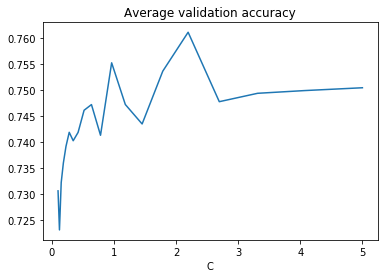

In [144]:
cv_and_test(X_final, Xts_final)